# Example joint fit between GBM and Swift BAT

One of the key features of 3ML is the abil ity to fit multi-messenger data properly. A simple example of this is the joint fitting of two instruments whose data obey different likelihoods. Here, we have GBM data which obey a Poisson-Gaussian profile likelihoog (<a href=http://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/manual/node293.html> PGSTAT</a> in XSPEC lingo) and Swift BAT which data which are the result of a "fit" via a coded mask and hence obey a Gaussian ( $\chi^2$ ) likelihood.


In [1]:
%matplotlib notebook
from threeML import *
import os

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


## Plugin setup

We have data from the same time interval from Swift BAT and a GBM NAI and BGO detector. We have preprocessed GBM data to so that it is OGIP compliant. (Remember that we can handle the raw data with the TimeSeriesBuilder). Thus, we will use the OGIPLike plugin to read in each dataset, make energy selections and examine the raw count spectra. 


### Swift BAT

Auto-probed noise models:
- observation: gaussian
- background: None
Range 15-150 translates to channels 3-62
Now using 60 channels out of 80



WARNING RuntimeWarning: Minimum MC energy (10.0) is larger than minimum EBOUNDS energy (0.0)



<IPython.core.display.Javascript object>


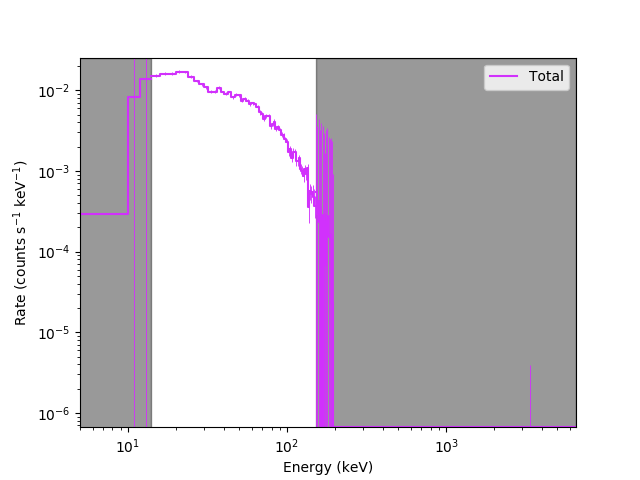


WARNING RuntimeWarning: invalid value encountered in sqrt



In [3]:
gbm_dir = "../../examples/gbm"
bat_dir = "../../examples/bat"

bat = OGIPLike('BAT',
               observation=os.path.join(bat_dir,'gbm_bat_joint_BAT.pha'),
               response=os.path.join(bat_dir,'gbm_bat_joint_BAT.rsp'))

bat.set_active_measurements('15-150')
bat.view_count_spectrum()

### Fermi GBM

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 8-900 translates to channels 2-124
Now using 123 channels out of 128



WARNING UserWarning: Field 5 has a repeat count of 0 in its format code, indicating an empty field.


WARNING UserWarning: The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.",)available: None 'EBOUNDS' 'SPECRESP MATRIX'


WARNING UserWarning: Could not find QUALITY in columns or header of PHA file. This is not a valid OGIP file. Assuming QUALITY =0 (good)



<IPython.core.display.Javascript object>


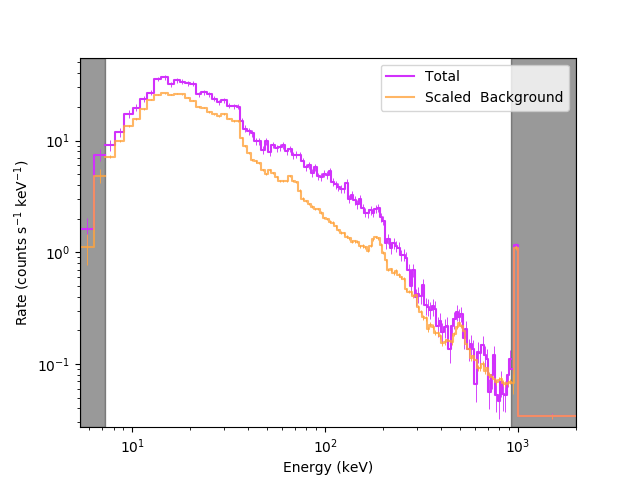

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 250-30000 translates to channels 1-119
Now using 119 channels out of 128


<IPython.core.display.Javascript object>


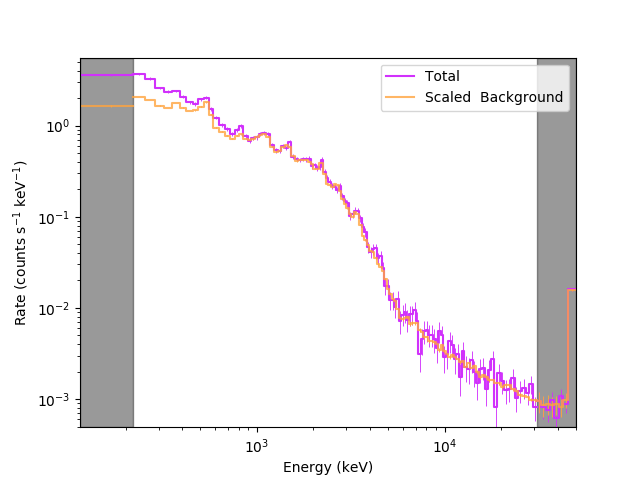

In [4]:
nai6 = OGIPLike('n6',
                os.path.join(gbm_dir,'gbm_bat_joint_NAI_06.pha'),
                os.path.join(gbm_dir,'gbm_bat_joint_NAI_06.bak'),
                os.path.join(gbm_dir,'gbm_bat_joint_NAI_06.rsp'),
                spectrum_number=1)


nai6.set_active_measurements('8-900')
nai6.view_count_spectrum()

bgo0 = OGIPLike('b0',
                os.path.join(gbm_dir,'gbm_bat_joint_BGO_00.pha'),
                os.path.join(gbm_dir,'gbm_bat_joint_BGO_00.bak'),
                os.path.join(gbm_dir,'gbm_bat_joint_BGO_00.rsp'),
                spectrum_number=1)

bgo0.set_active_measurements('250-30000')
bgo0.view_count_spectrum()

## Model setup

We setup up or spectrum and likelihood model and combine the data. 3ML will automatically assign the proper likelihood to each data set. At first, we will assume a perfect calibration between the different detectors and not a apply a so-called effective area correction. 

In [7]:
band = Band()

model_no_eac = Model(PointSource('joint_fit_no_eac',0,0,spectral_shape=band))


## Spectral fitting

Now we simply fit the data by building the data list, creating the joint likelihood and running the fit.

### No effective area correction

In [8]:
data_list = DataList(bat,nai6,bgo0)

jl_no_eac = JointLikelihood(model_no_eac, data_list)

jl_no_eac.fit();

Best fit values:



,result,unit
parameter,,
joint_fit_no_eac.spectrum.main.Band.K,(2.750 +/- 0.06) x 10^-2,1 / (cm2 keV s)
joint_fit_no_eac.spectrum.main.Band.alpha,-1.029 +/- 0.017,
joint_fit_no_eac.spectrum.main.Band.xp,(5.700 +/- 0.4) x 10^2,keV
joint_fit_no_eac.spectrum.main.Band.beta,-2.410 +/- 0.18,



Correlation matrix:



1.00,0.90,-0.85,0.14
0.90,1.00,-0.73,0.08
-0.85,-0.73,1.00,-0.32
0.14,0.08,-0.32,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BAT,53.045232
b0,553.071766
n6,761.174119
total,1367.291117



Values of statistical measures:



,statistical measures
AIC,2742.716915
BIC,2757.423943


The fit has resulted in a very typical Band function fit. Let's look in count space at how good of a fit we have obtained.

In [10]:
threeML_config['ogip']['model plot cmap']='Set1'

<IPython.core.display.Javascript object>


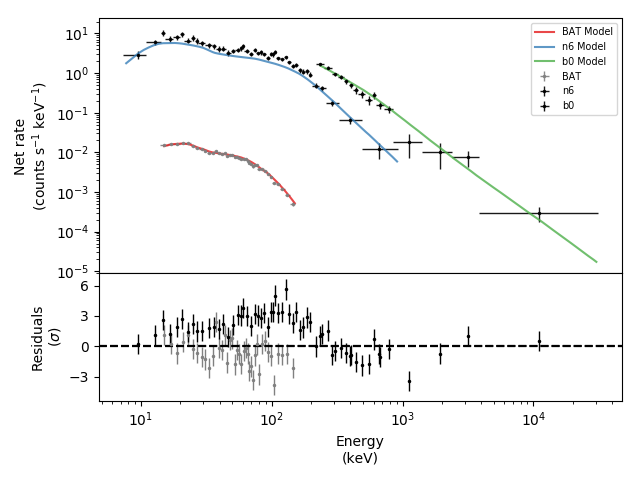

In [12]:
display_spectrum_model_counts(jl_no_eac, step=False, min_rate=[.01,10.,10.],data_colors=['grey','k','k']);

It seems that the effective areas between GBM and BAT do not agree! We can look at the goodness of fit for the various data sets.

In [24]:
gof_object = GoodnessOfFit(jl_no_eac)

with parallel_computation(profile='default',start_cluster=False):

    gof, res_frame, lh_frame = gof_object.by_mc(n_iterations=8000)
    
    

Now using 80 channels out of 80
Now using 128 channels out of 128
Now using 128 channels out of 128


VBox(children=(HTML(value=u''), HTML(value=u''), FloatProgress(value=0.0)))

In [27]:
import pandas as pd
pd.Series(gof)

total    0.00000
BAT      0.00000
n6       0.00000
b0       0.50575
dtype: float64

Both the GBM NaI detector and Swift BAT exhibit poor GOF.

### With effective are correction

Now let's add an effective area correction between the detectors to see if this fixes the problem. The effective area is a nuissance parameter that attempts to model systematic problems in a instruments calibration. It simply scales the counts of an instrument by a multiplicative factor. It cannot handle more complicated energy dependent 

In [35]:
# turn on the effective area correction and set it's bounds
nai6.use_effective_area_correction(.2,1.8)
bgo0.use_effective_area_correction(.2,1.8)

model_eac = Model(PointSource('joint_fit_eac',0,0,spectral_shape=band))

jl_eac = JointLikelihood(model_eac, data_list)

jl_eac.fit();


Best fit values:



,result,unit
parameter,,
joint_fit_eac.spectrum.main.Band.K,(2.980 +/- 0.12) x 10^-2,1 / (cm2 keV s)
joint_fit_eac.spectrum.main.Band.alpha,(-9.840 +/- 0.26) x 10^-1,
joint_fit_eac.spectrum.main.Band.xp,(3.310 +/- 0.32) x 10^2,keV
joint_fit_eac.spectrum.main.Band.beta,-2.360 +/- 0.15,
cons_n6,1.560 +/- 0.04,
cons_b0,1.410 +/- 0.10,



Correlation matrix:



1.00,0.95,-0.92,0.31,0.29,0.62
0.95,1.00,-0.82,0.26,0.26,0.52
-0.92,-0.82,1.00,-0.36,-0.45,-0.77
0.31,0.26,-0.36,1.00,0.04,-0.03
0.29,0.26,-0.45,0.04,1.00,0.47
0.62,0.52,-0.77,-0.03,0.47,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BAT,40.065347
b0,544.751052
n6,644.715613
total,1229.532012



Values of statistical measures:



,statistical measures
AIC,2471.348770
BIC,2493.326586


Now we have a much better fit to all data sets

<IPython.core.display.Javascript object>


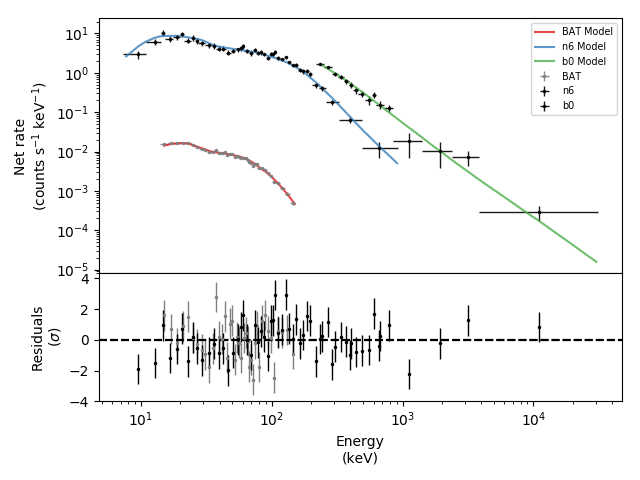

In [36]:
display_spectrum_model_counts(jl_eac, step=False,min_rate=[.01,10.,10.],data_colors=['grey','k','k']);

In [32]:
gof_object = GoodnessOfFit(jl_eac)

with parallel_computation(profile='default',start_cluster=False):

    gof, res_frame, lh_frame = gof_object.by_mc(n_iterations=8000,continue_on_failure=True)
    

Now using 80 channels out of 80
Now using 128 channels out of 128
Now using 128 channels out of 128


VBox(children=(HTML(value=u''), HTML(value=u''), FloatProgress(value=0.0)))

In [33]:
import pandas as pd
pd.Series(gof)

total    0.033500
BAT      0.023500
n6       0.015250
b0       0.702625
dtype: float64

## Examining the differences

Let's plot the fits in model space and see how different the resulting models are.


VBox(children=(HTML(value=u'Propagating errors : '), HTML(value=u''), FloatProgress(value=0.0)))

VBox(children=(HTML(value=u'Propagating errors : '), HTML(value=u''), FloatProgress(value=0.0)))

<IPython.core.display.Javascript object>


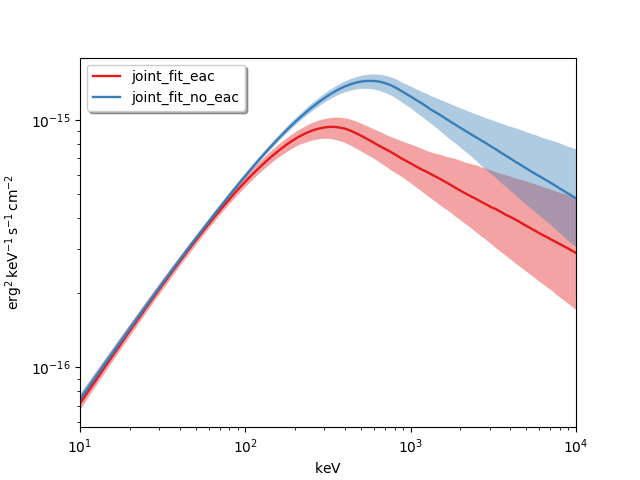

In [44]:


plot_point_source_spectra(jl_eac.results,
                          jl_no_eac.results,
                          fit_cmap = 'Set1',
                          contour_cmap = 'Set1',
                          flux_unit='erg2/(keV s cm2)',
                          equal_tailed=True);

We can easily see that the models are different 